In [2]:
import pandas as pd
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [10]:
# Quarterly data: 180-period test set, 7 variables

arfit_all = pyreadr.read_r('../SVol Benchmarks/arfit_all_monthly.RData')['arfit_all'].to_numpy().T
svfit_all = pyreadr.read_r('../SVol Benchmarks/svfit_all_monthly.RData')['svfit_all'].to_numpy().T
Y = pd.read_csv('../SVol Benchmarks/monthlyData_updated.csv')
Y = Y.drop(columns=['Unnamed: 0', 'Date'])
# Subset to only test set
Y = Y.iloc[-178:, :]
var_names = list(Y.columns)

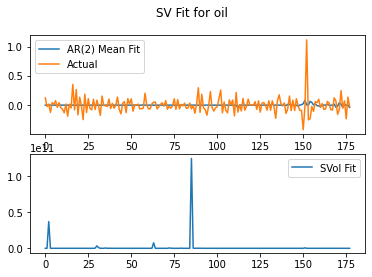

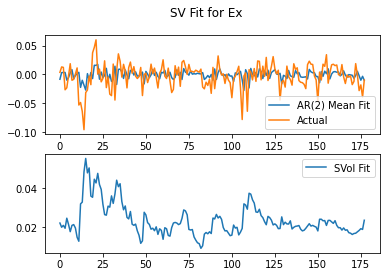

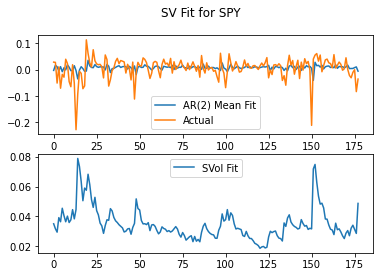

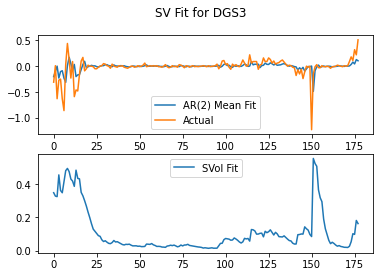

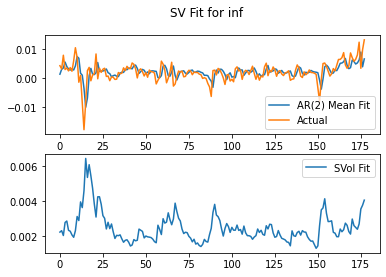

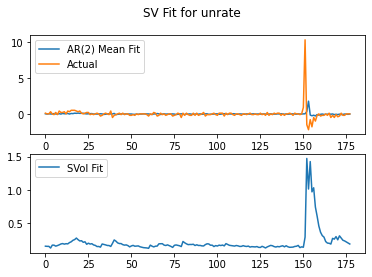

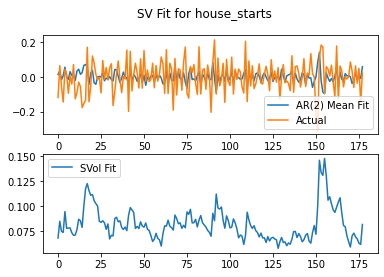

In [11]:
# Plot y and the predicted mean in a graph
for var_num in range(Y.shape[1]):
    y = Y.iloc[:,var_num].to_numpy()
    ar = arfit_all[:,var_num]
    sv = svfit_all[:, var_num]
    
    # Create a 2x1 subplot, plotting arfit_all and y in the first plot, and svfit_all in the second plot
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('SV Fit for ' + Y.columns[var_num])
    ax1.plot(ar, label='AR(2) Mean Fit')
    ax1.plot(y, label='Actual')
    ax1.legend()
    ax2.plot(sv, label='SVol Fit')
    ax2.legend()
    plt.show()

### Getting Predictive Density Scores

In [12]:
# Mean across all bootstraps: all are same size (n_obs x n_vars)
# Remove COVID (last 8 obs)
covid_to_remove = 30

preds_test_mean = arfit_all[:-covid_to_remove, :]
sigmas_mean = svfit_all[:-covid_to_remove, :]
Y_test = Y.to_numpy()[:-covid_to_remove, :]

In [13]:
PRED_DENSITY_MARG_ALL = np.zeros((1, preds_test_mean.shape[0], preds_test_mean.shape[1]))
PRED_DENSITY_MARG_ALL[:] = np.nan
# Loop over all time steps
for t in range(preds_test_mean.shape[0]):
  pred_mean = preds_test_mean[t, :]
  pred_sigma = sigmas_mean[t, :]
  y_test = Y_test[t, :]
  
  for var in range(preds_test_mean.shape[1]):
    # Construct a univariate normal with pred_mean and pred_sigma
    univ_norm = multivariate_normal(pred_mean[var], pred_sigma[var])
    # Evaluate density at y_test
    log_density = univ_norm.logpdf(y_test[var])
    PRED_DENSITY_MARG_ALL[0, t, var] = log_density
  

In [14]:
# Make dataframe wtih sum and mean of predictive density as the 2 columns
marginal_density_df = pd.DataFrame()
for var in range(preds_test_mean.shape[1]):
  marginal_density_df_var = pd.DataFrame({'Mean': PRED_DENSITY_MARG_ALL[:, :, var].mean(axis=1),
                        'Median': np.median(PRED_DENSITY_MARG_ALL[:, :, var], axis=1),
                        '10th': np.percentile(PRED_DENSITY_MARG_ALL[:, :, var], 10, axis=1),
                        '90th': np.percentile(PRED_DENSITY_MARG_ALL[:, :, var], 90, axis=1),
                        'Variable': var_names[var]
                        })
  
  marginal_density_df = pd.concat([marginal_density_df, marginal_density_df_var], axis=0).reset_index(drop=True)

In [15]:
marginal_density_df

,Mean,Median,10th,90th,Variable
0,-8.151712,-8.009523,-9.979441,-6.549767,oil
1,0.961661,0.996935,0.728622,1.139194,Ex
2,0.767162,0.779814,0.623606,0.922837,SPY
3,0.426897,0.488717,-0.417444,0.979812,DGS3
4,2.112986,2.135528,1.924850,2.277899,inf
5,-0.111372,-0.069789,-0.306070,0.017451,unrate
6,0.307965,0.320286,0.185160,0.413029,house_starts


Text(0, 0.5, 'Log Density')

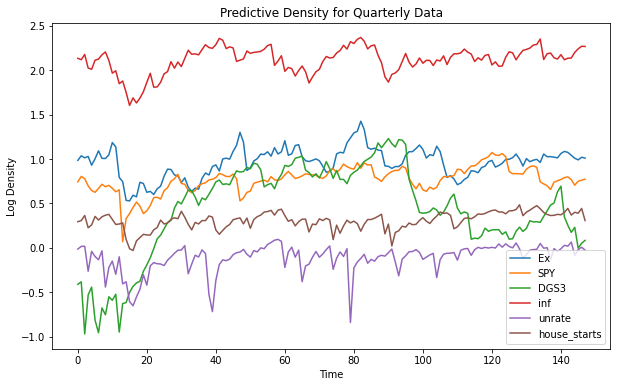

In [17]:
# Plot the log density for each variable
plt.figure( figsize=(10, 6))
for var_num in range(1, Y.shape[1]):
  plt.plot(PRED_DENSITY_MARG_ALL[0, :, var_num], label=Y.columns[var_num])
  # Set legend 
  plt.legend()

# Set title of plot
plt.title('Predictive Density for Quarterly Data')
# Set x-axis label
plt.xlabel('Time')
# Set y-axis label
plt.ylabel('Log Density')